# Run a trained policy

This notebook will provide examples on how to run a trained policy and visualize the rollout.

In [1]:
import isaacgym
import isaacgymenvs
from hydra import compose, initialize_config_dir
from omegaconf import OmegaConf
from pathlib import Path

plt_root = Path("../../../policy_learning_toolkit/").expanduser()
igenvs_root = Path("~/diff_manip/external/IsaacGymEnvs").expanduser()

import argparse
import json
import h5py
import yaml
import isaacgym
import imageio
import numpy as np
import os
from copy import deepcopy

import torch

import robomimic
import robomimic.utils.file_utils as FileUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
from robomimic.envs.env_base import EnvBase
from robomimic.algo import RolloutPolicy

# from stable_baselines3.buffers.


import urllib.request


Importing module 'gym_38' (/home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


In [1]:
import sys, os
import matplotlib.pyplot as plt
from isaacgym import gymapi
sys.path.append(os.path.expanduser("../"))
from env_bidex import create_bidex_env
env = create_bidex_env("ShadowHandBottleCap", "ppo", False)

Importing module 'gym_38' (/home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/krishnans/carbgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
PyTorch version 2.0.1+cu117
Device count 1
/home/krishnans/carbgym/python/isaacgym/_bindings/src/gymtorch


Using /home/krishnans/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/krishnans/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gymtorch...


ninja: no work to do.
Averaging factor:  0.01
Obs type: full_state


: 

In [ ]:
from isaacgym import gymapi
import numpy as np
q = gymapi.Quat.from_euler_zyx(0.0, np.pi/4, 0)
q.x, q.y, q.z, q.w

(0.0, 0.3826834559440613, 0.0, 0.9238795042037964)

In [ ]:
env.step(torch.zeros(env.action_space.sample()[None].shape, device=env.task.device))

(tensor([[ 5.1515e-01,  1.1930e-01, -7.9358e-02, -8.2401e-01, -7.9298e-01,
          -9.6200e-01,  6.0816e-03, -8.0287e-01, -7.9335e-01, -9.6247e-01,
           3.7759e-02, -8.2604e-01, -7.9390e-01, -9.6224e-01, -8.4650e-01,
           5.0599e-02, -8.3209e-01, -7.9750e-01, -9.6417e-01, -4.5744e-01,
           8.9528e-01,  1.0006e+00,  1.6953e-01, -7.7385e-01, -1.2651e-01,
          -2.3035e-01, -2.1646e-01,  9.3410e-01,  1.2116e+00,  3.3046e-01,
           2.1411e-02,  1.1636e+00,  1.2029e+00,  3.2547e-01,  1.0636e-01,
           9.2175e-01,  1.2113e+00,  3.2768e-01,  4.9419e-01,  1.3579e-01,
           9.1368e-01,  1.1941e+00,  3.1061e-01,  1.9705e+00, -6.7281e-01,
          -1.0319e-02,  9.1766e-01,  1.2711e+00,  1.5503e+00, -1.0589e-01,
           6.7013e-02, -6.3405e-01, -3.8059e-01, -1.6480e-01, -3.8217e-02,
          -6.4450e-01, -3.8366e-01, -1.6468e-01, -7.8677e-02, -6.6475e-01,
          -3.8794e-01, -1.6562e-01, -7.2624e-01, -1.6677e-01, -8.5771e-01,
          -4.4706e-01, -1

In [1]:
import pandas as pd
import os

# Directory containing the CSV files
csv_dir = os.path.expanduser("~/multi_task_experts/collect_myosuite/tdmpc2/results")

# List of CSV files
csv_files = [
    "myo-hand-key-turn.csv",
    "myo-hand-key-turn-hard.csv",
    "myo-hand-obj-hold.csv",
    "myo-hand-obj-hold-hard.csv",
    "myo-hand-pen-twirl.csv",
    "myo-hand-pen-twirl-hard.csv",
    "myo-hand-pose.csv",
    "myo-hand-pose-hard.csv",
    "myo-hand-reach.csv",
    "myo-hand-reach-hard.csv"
]

# Dictionary to store DataFrames
dataframes = {}

# Load each CSV file into a DataFrame
for csv_file in csv_files:
    file_path = os.path.join(csv_dir, csv_file)
    if os.path.exists(file_path):
        task_name = csv_file.replace("myo-hand-", "").replace(".csv", "")
        dataframes[task_name] = pd.read_csv(file_path)
    else:
        print(f"File not found: {file_path}")

# Print the names of successfully loaded DataFrames
print("Loaded DataFrames:")
for task_name in dataframes.keys():
    print(f"- {task_name}")

Loaded DataFrames:
- key-turn
- key-turn-hard
- obj-hold
- obj-hold-hard
- pen-twirl
- pen-twirl-hard
- pose
- pose-hard
- reach
- reach-hard

First few rows of 'key-turn' DataFrame:
     step  success  seed
0       0      0.0     1
1   50000      0.0     1
2  100000      1.0     1
3  150000      1.0     1
4  200000      1.0     1


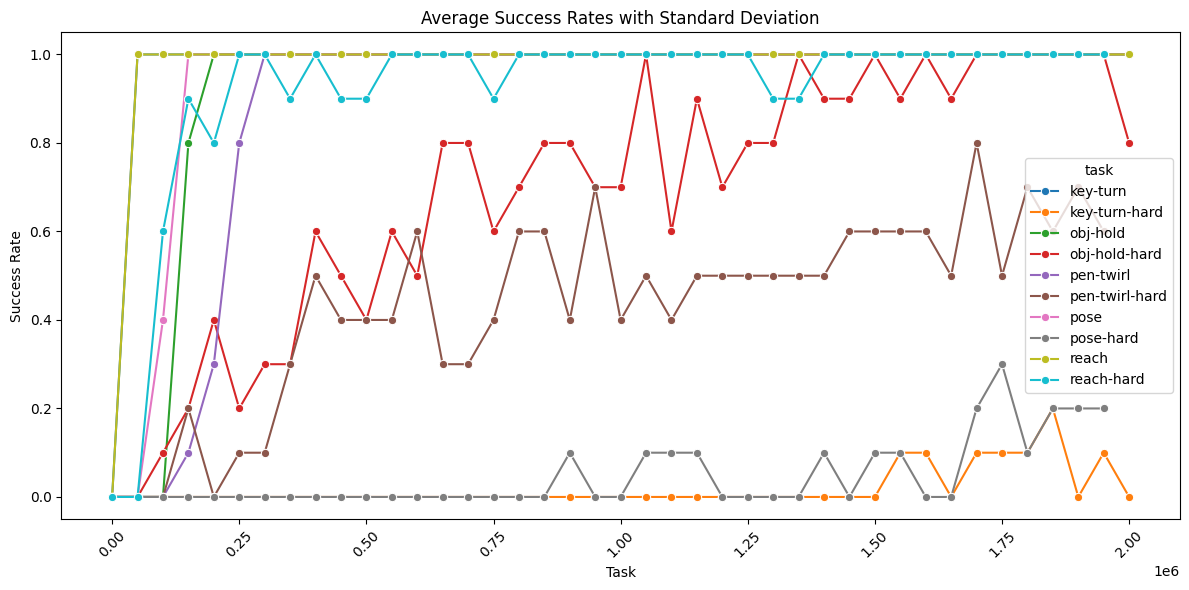


Task Statistics:
               task      mean       std       step  max
0          key-turn  0.961157  0.184559        NaN  NaN
1     key-turn-hard  0.007438  0.029341        NaN  NaN
2          obj-hold  0.864463  0.312479        NaN  NaN
3     obj-hold-hard  0.561157  0.297874        NaN  NaN
4         pen-twirl  0.671667  0.441004        NaN  NaN
...             ...       ...       ...        ...  ...
1223     reach-hard  0.833333  0.208167  1750000.0  1.0
1224     reach-hard  0.966667  0.057735  1800000.0  1.0
1225     reach-hard  0.933333  0.115470  1850000.0  1.0
1226     reach-hard  0.966667  0.057735  1900000.0  1.0
1227     reach-hard  0.966667  0.057735  1950000.0  1.0

[1228 rows x 5 columns]


In [10]:

# Compute average success rates and standard deviations across seeds and steps
task_stats = {}
for task, df in dataframes.items():
    # Group by step, then calculate mean and std success rate across seeds
    grouped = df.groupby('step')['success'].agg(['mean', 'std', 'max']).reset_index()
    grouped['task'] = task
    
    if 'stats_df' not in locals():
        stats_df = grouped
    else:
        stats_df = pd.concat([stats_df, grouped], ignore_index=True)

# Plot line plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='step', y='max', hue='task', data=stats_df, marker='o')
# plt.fill_between(stats_df['step'], 
#                  stats_df['mean'] - stats_df['std'],
#                  stats_df['mean'] + stats_df['std'],
#                  alpha=0.3)

plt.title('Average Success Rates with Standard Deviation')
plt.xlabel('Task')
plt.ylabel('Success Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nTask Statistics:")
print(stats_df)


In [18]:
tasks

{'key-turn': {'max_success': 1.0, 'std_dev': 0.02585987819640146},
 'key-turn-hard': {'max_success': 0.2, 'std_dev': 0.011694061396536492},
 'obj-hold': {'max_success': 1.0, 'std_dev': 0.07833092860191476},
 'obj-hold-hard': {'max_success': 1.0, 'std_dev': 0.13241812968300506},
 'pen-twirl': {'max_success': 1.0, 'std_dev': 0.26967991521823304},
 'pen-twirl-hard': {'max_success': 0.8, 'std_dev': 0.10357594915805449},
 'pose': {'max_success': 1.0, 'std_dev': 0.025283848952834035},
 'pose-hard': {'max_success': 0.3, 'std_dev': 0.02431844345985836},
 'reach': {'max_success': 1.0, 'std_dev': 0.01666247853780537},
 'reach-hard': {'max_success': 1.0, 'std_dev': 0.11793107187914058}}

In [19]:
tasks = {}

for task in stats_df.task.unique():
    task_data = stats_df[stats_df.task == task]
    max_success = task_data["max"].max()
    std_dev = task_data["std"].mean()  # Using mean of std dev across steps
    tasks[task] = {
        'max_success': max_success,
        'std_dev': std_dev
    }

# Create a DataFrame from the tasks dictionary
df = pd.DataFrame.from_dict(tasks, orient='index', columns=['max_success', 'std_dev'])
df.index.name = 'Task'
df = df.reset_index()

# Round the values to 2 decimal places
df['max_success'] = df['max_success'].round(2)
df['std_dev'] = df['std_dev'].round(2)

# Generate and print a markdown table
markdown_table = df.to_markdown(index=False)
print("Markdown Table:")
print(markdown_table)

# Generate and print a LaTeX table
latex_table = df.to_latex(index=False)
print("\nLaTeX Table:")
print(latex_table)

Markdown Table:
| Task           |   max_success |   std_dev |
|:---------------|--------------:|----------:|
| key-turn       |           1   |      0.03 |
| key-turn-hard  |           0.2 |      0.01 |
| obj-hold       |           1   |      0.08 |
| obj-hold-hard  |           1   |      0.13 |
| pen-twirl      |           1   |      0.27 |
| pen-twirl-hard |           0.8 |      0.1  |
| pose           |           1   |      0.03 |
| pose-hard      |           0.3 |      0.02 |
| reach          |           1   |      0.02 |
| reach-hard     |           1   |      0.12 |

LaTeX Table:
\begin{tabular}{lrr}
\toprule
Task & max_success & std_dev \\
\midrule
key-turn & 1.000000 & 0.030000 \\
key-turn-hard & 0.200000 & 0.010000 \\
obj-hold & 1.000000 & 0.080000 \\
obj-hold-hard & 1.000000 & 0.130000 \\
pen-twirl & 1.000000 & 0.270000 \\
pen-twirl-hard & 0.800000 & 0.100000 \\
pose & 1.000000 & 0.030000 \\
pose-hard & 0.300000 & 0.020000 \\
reach & 1.000000 & 0.020000 \\
reach-hard & 1.000

In [5]:
pd.read_csv("Method Comparison.csv")

,Task,BC-RNN,ACT,DistillACT,MT-TDMPC2,TDMPC2 (Expert)
0,KeyTurn,0.79,0.82,1.00,0.20,1.00
1,KeyTurnHard,0.04,0.02,0.12,0.00,0.07
2,ObjHold,0.67,0.81,0.98,0.00,1.00
3,ObjHoldHard,0.58,0.72,0.81,0.00,0.90
4,PenTwirl,0.82,0.84,0.89,0.12,1.00
5,PenTwirlHard,0.39,0.58,0.58,0.00,0.47
6,Pose,0.88,0.90,0.93,0.00,1.00
7,PoseHard,0.42,0.96,0.99,0.00,0.20
8,Reach,0.85,0.84,0.99,0.10,1.00
9,ReachHard,0.59,0.76,0.74,0.00,0.97


<Figure size 1600x600 with 0 Axes>

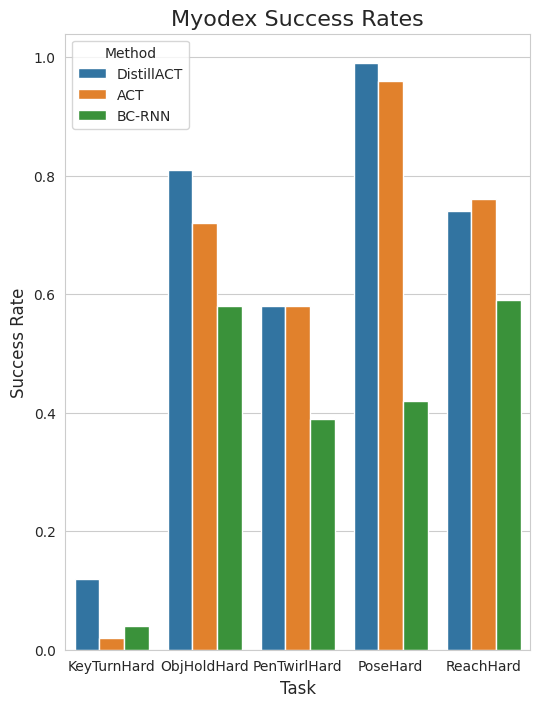

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set the style and figure size
sns.set_style("whitegrid")
plt.figure(figsize=(16, 6))

# Create two subplots
fig, ax1 = plt.subplots(1, 1, figsize=(6, 8))

# Data for the first plot (Myodex Success Rates)
data1 = {
    'Task': ['KeyTurnHard', 'KeyTurnHard', 'KeyTurnHard',
             'ObjHoldHard', 'ObjHoldHard', 'ObjHoldHard',
             'PenTwirlHard', 'PenTwirlHard', 'PenTwirlHard',
             'PoseHard', 'PoseHard', 'PoseHard',
             'ReachHard', 'ReachHard', 'ReachHard'],
    'Method': ['DistillACT', 'ACT', 'BC-RNN'] * 5,
    'Success Rate': [0.12, 0.02, 0.04,
                     0.81, 0.72, 0.58,
                     0.58, 0.58, 0.39,
                     0.99, 0.96, 0.42,
                     0.74, 0.76, 0.59]
}

df1 = pd.DataFrame(data1)

# Plot the first subplot
sns.barplot(x='Task', y='Success Rate', hue='Method', data=df1, ax=ax1)
ax1.set_title('Myodex Success Rates', fontsize=16)
ax1.set_xlabel('Task', fontsize=12)
ax1.set_ylabel('Success Rate', fontsize=12)
ax1.legend(title='Method', loc='upper left')

# Data for the second plot (Critic Loss per task)
# tasks = ['KeyTurnHard', 'ObjHoldHard', 'PenTwirlHard', 'PoseHard', 'ReachHard']
# critic_loss = [-0.25, -0.9, -0.57, -0.1, -1.15]

# # Plot the second subplot
# sns.barplot(x=tasks, y=critic_loss, ax=ax2)
# ax2.set_title('Critic Loss per task (-E[Q(s,a)])', fontsize=16)
# ax2.set_xlabel('Task', fontsize=12)
# ax2.set_ylabel('Critic Loss', fontsize=12)

# # Adjust the y-axis to match the image
# ax2.set_ylim(-1.2, 0)

# # Add value labels on top of each bar
# for i, v in enumerate(critic_loss):
#     ax2.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# # Adjust layout and display the plot
# plt.tight_layout()
# plt.show()

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_1703221/3705065509.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=tasks, x=adjusted_critic_loss, ax=ax2, palette='tab10', orient='h')


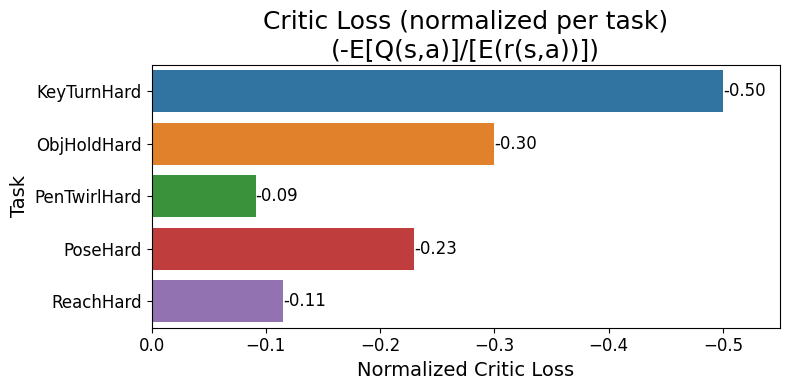

In [13]:
# Data for the second plot (Critic Loss per task)
tasks = ['KeyTurnHard', 'ObjHoldHard', 'PenTwirlHard', 'PoseHard', 'ReachHard']
critic_loss = [-0.25, -0.9, -0.57, -0.1, -1.15]
coefficients = [2, 0.333, 0.16, 2.3, 0.1]

# Apply coefficients to critic_loss
adjusted_critic_loss = [loss * coeff for loss, coeff in zip(critic_loss, coefficients)]

# Create the plot
fig, ax2 = plt.subplots(1, 1, figsize=(8, 4))  # Reduced height from 6 to 4

# Plot using tab10 color palette
sns.barplot(y=tasks, x=adjusted_critic_loss, ax=ax2, palette='tab10', orient='h')
ax2.set_title('Critic Loss (normalized per task)\n(-E[Q(s,a)]/[E(r(s,a))])', fontsize=18)  # Increased from 16
ax2.set_ylabel('Task', fontsize=14)  # Increased from 12
ax2.set_xlabel('Normalized Critic Loss', fontsize=14)  # Increased from 12

# Set x-axis limits from 0 to -0.55
ax2.set_xlim(0, -0.55)

# Add value labels to the right of each bar
for i, v in enumerate(adjusted_critic_loss):
    ax2.text(v, i, f'{v:.2f}', va='center', ha='left', fontsize=12)  # Added fontsize

# Increase tick label font size
ax2.tick_params(axis='both', which='major', labelsize=12)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

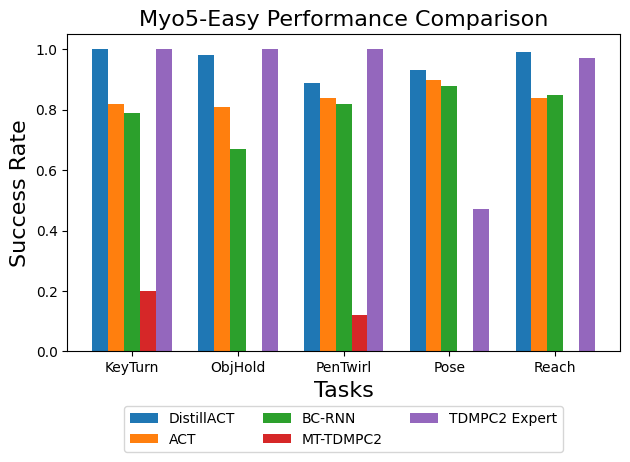

In [6]:
fig, ax = plt.subplots()
for i, label in enumerate(labels):
    ax.bar(x + (i - 2) * width, data[i], width, label=label)

ax.set_xlabel('Tasks', fontsize=16)
ax.set_ylabel('Success Rate', fontsize=16)
ax.set_title('Myo5-Easy Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(tasks)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

fig.tight_layout()

plt.show()


In [ ]:
env.task.obs_dict['fixed_camera'].shape

KeyError: 'fixed_camera'

/tmp/ipykernel_2426057/3025888719.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='Vision Models', y='Success Rate', ci=None, palette=sns.color_palette("Set1", n_colors=3))
/tmp/ipykernel_2426057/3025888719.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Vision Models', y='Success Rate', ci=None, palette=sns.color_palette("Set1", n_colors=3))


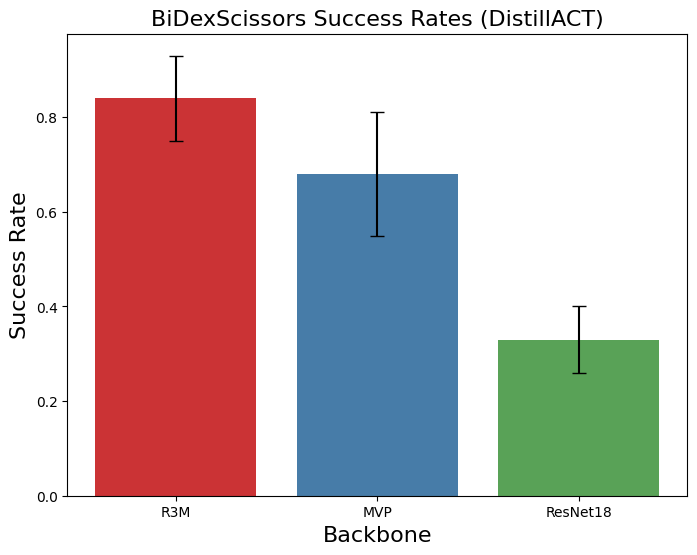

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'Vision Models': ['R3M', 'MVP', 'ResNet18'],
    'Success Rate': [0.84, 0.68, 0.33],
    'Error': [0.09, 0.13, 0.07]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Vision Models', y='Success Rate', ci=None, palette=sns.color_palette("Set1", n_colors=3))

# Add error bars
plt.errorbar(x=range(len(df['Vision Models'])), y=df['Success Rate'], yerr=df['Error'], fmt='none', c='black', capsize=5)

# Add labels and title
plt.xlabel('Backbone', fontsize=16)
plt.ylabel('Success Rate', fontsize=16)
plt.title('BiDexScissors Success Rates (DistillACT)', fontsize=16)

# Show the plot
plt.show()


In [ ]:
ls /home/krishnans/ngc/robomimic/bc_rnn_trained_models/test-r3m/**/models/

model_epoch_50.pth


In [ ]:

ckpt_path = "/home/krishnans/ngc/robomimic/act_trained_models/ACT++_Bidex_Switch/20240513051804/models/model_epoch_800.pth"

policy, ckpt_dict = FileUtils.policy_from_checkpoint(
    ckpt_path=ckpt_path, 
    device='cuda:0', 
    verbose=True
)

============= Loaded Config =============
{
    "algo_name": "act",
    "experiment": {
        "name": "ACT++_Bidex_Switch",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": true,
            "wandb_proj_name": "robomimic"
        },
        "mse": {
            "enabled": false,
            "every_n_epochs": 50,
            "on_save_ckpt": true,
            "num_samples": 20,
            "visualize": true
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 40,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 500,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": true,
 

/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Use VQ: True, 512, 64
number of parameters: 117.86M
============= Loaded Policy =============
ACT (
  ModuleDict(
    (policy): DETRVAE(
      (transformer): Transformer(
        (encoder): TransformerEncoder(
          (layers): ModuleList(
            (0-3): 4 x TransformerEncoderLayer(
              (self_attn): MultiheadAttention(
                (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
              )
              (linear1): Linear(in_features=512, out_features=3200, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (linear2): Linear(in_features=3200, out_features=512, bias=True)
              (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (dropout1): Dropout(p=0.1, inplace=False)
              (dropout2): Dropout(p=0.1, inplace=False)
            )
          )
        )
        (decoder): Transfo

In [ ]:
config = yaml.safe_load(open("/home/krishnans/ngc/robomimic/act_trained_models/ACT++_Bidex_Switch/20240513051804/config.json"))

In [ ]:
config

{'algo_name': 'act',
 'experiment': {'name': 'ACT++_Bidex_Switch',
  'validate': False,
  'logging': {'terminal_output_to_txt': True,
   'log_tb': True,
   'log_wandb': True,
   'wandb_proj_name': 'robomimic'},
  'mse': {'enabled': False,
   'every_n_epochs': 50,
   'on_save_ckpt': True,
   'num_samples': 20,
   'visualize': True},
  'save': {'enabled': True,
   'every_n_seconds': None,
   'every_n_epochs': 40,
   'epochs': [],
   'on_best_validation': False,
   'on_best_rollout_return': False,
   'on_best_rollout_success_rate': True},
  'epoch_every_n_steps': 500,
  'validation_epoch_every_n_steps': 10,
  'env': None,
  'additional_envs': None,
  'render': False,
  'render_video': True,
  'keep_all_videos': False,
  'video_skip': 5,
  'rollout': {'enabled': False,
   'n': 50,
   'horizon': 400,
   'rate': 40,
   'warmstart': 0,
   'terminate_on_success': True,
   'batched': False,
   'num_batch_envs': 5},
  'env_meta_update_dict': {},
  'ckpt_path': None},
 'train': {'data': [{'path':

In [ ]:
hdf5_path = "/home/krishnans/ngc/bidex_datasets"

In [ ]:
ls {hdf5_path}/**/*.hdf5

/home/krishnans/ngc/bidex_datasets/scissors/rollouts_1000.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_1000_no_img.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_100.hdf5
/home/krishnans/ngc/bidex_datasets/scissors/rollouts_500.hdf5
/home/krishnans/ngc/bidex_datasets/switch/rollouts_100.hdf5
/home/krishnans/ngc/bidex_datasets/switch/rollouts_500.hdf5


In [ ]:
import h5py
hdf5_path = f"{hdf5_path}/switch/rollouts_100.hdf5"

data = h5py.File(hdf5_path, "r")
cam_obs_keys = list(filter(lambda x: "camera" in x, list(data["data/demo_0/obs"].keys())))
cam_obs_keys

In [ ]:

cam_obs_key = cam_obs_keys[0]
d_idx = 0
data_dict = {'obs': {cam_obs_key: data[f'data/demo_{d_idx}/obs/fixed_camera'][:]},
             'actions': data[f'data/demo_{d_idx}/actions'][:]}
tensor_data_dict = TensorUtils.to_device(TensorUtils.to_tensor(data_dict), policy.policy.device)
input_dict = policy.policy.process_batch_for_training(tensor_data_dict)
input_dict = policy.policy.postprocess_batch_for_training(input_dict, obs_normalization_stats=None)


import matplotlib.pyplot as plt

obs_encoder = policy.policy.nets['policy'].nets['encoder'].nets['obs']
obs_randomizer = obs_encoder.obs_randomizers[cam_obs_key]
obs_net = obs_encoder.obs_nets[cam_obs_key] # Spatial Softmax
backbone = obs_net.nets[:1]

# obs_processed = obs_randomizer[0].forward_in(tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)).requires_grad_(True)
obs_processed = tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2).requires_grad_(True)

KeyError: 'pad_mask'

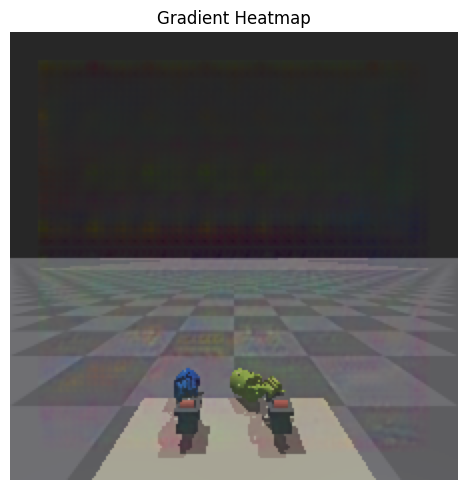

In [ ]:
import matplotlib.pyplot as plt

cam_obs_key = 'fixed_camera'
obs_encoder = policy.policy.nets['policy'].nets['encoder'].nets['obs']
obs_randomizer = obs_encoder.obs_randomizers[cam_obs_key]
obs_net = obs_encoder.obs_nets[cam_obs_key] # Spatial Softmax
backbone = obs_net.nets[:1]

# obs_processed = obs_randomizer[0].forward_in(tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2)).requires_grad_(True)
obs_processed = tensor_data_dict['obs'][cam_obs_key].permute(0, 3, 1, 2).requires_grad_(True)

obs_backbone_feat = backbone(obs_processed).sum().backward()
# weights = obs_net.nets[1](obs_backbone_feat).mean().backward()

# indices = weights.argmax(dim=-1).to(torch.int64).detach()

# num_keypoints = indices.shape[-1] // 2
# x_indices = indices[..., :num_keypoints] 
# y_indices = indices[..., num_keypoints:]

# max_features = obs_backbone_feat[torch.arange(obs_backbone_feat.shape[0]).unsqueeze(-1), 
#                                  y_indices, 
#                                  x_indices]
# sum_max_features = max_features.sum(dim=1)

# sum_max_features.sum().backward()

# Normalize the gradients for visualization
gradients = obs_processed.grad
gradients = gradients - gradients.min() 
gradients /= torch.nn.functional.softmax(gradients, dim=1)



idx = 120
img = obs_processed[idx].permute(1, 2, 0).detach().cpu().numpy()

# Upsample the gradients to match the original image size
# gradients_upsampled = torch.nn.functional.interpolate(gradients, size=img.shape, mode='bilinear', align_corners=False)
gradients_upsampled = gradients.cpu().numpy()[idx].transpose(1, 2, 0)

# Convert to numpy and transpose (H, W, C)
# gradients_upsampled = gradients_upsampled.cpu().numpy()[0].transpose(1, 2, 0)

# Plot the gradient heatmap on top of the original image
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(img)  
ax.imshow(gradients_upsampled, cmap='jet', alpha=0.5)
ax.set_title("Gradient Heatmap")
ax.axis('off')

plt.tight_layout()
plt.show()


### Download policy checkpoint
First, let's try downloading a pretrained model from our model zoo.

In [ ]:
# Get pretrained checkpooint from the model zoo

ckpt_path = "lift_ph_low_dim_epoch_1000_succ_100.pth"
# Lift (Proficient Human)
urllib.request.urlretrieve(
    "http://downloads.cs.stanford.edu/downloads/rt_benchmark/model_zoo/lift/bc_rnn/lift_ph_low_dim_epoch_1000_succ_100.pth",
    filename=ckpt_path
)

assert os.path.exists(ckpt_path)

In [ ]:
ckpt_path = "/home/krishnans/ngc/policy_learning_toolkit/train/trained_models/bc_rnn_trained_models/bidex_scissors_switch_rnn/models/model_epoch_2000.pth"

### Loading trained policy
We have a convenient function called `policy_from_checkpoint` that takes care of building the correct model from the checkpoint and load the trained weights. Of course you could also load the checkpoint manually.

In [ ]:
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=True)

============= Loaded Config =============
{
    "algo_name": "bc",
    "experiment": {
        "name": "bidex_scissors_switch_rnn",
        "validate": false,
        "logging": {
            "terminal_output_to_txt": true,
            "log_tb": true,
            "log_wandb": true,
            "wandb_proj_name": "robomimic"
        },
        "mse": {
            "enabled": false,
            "every_n_epochs": 50,
            "on_save_ckpt": true,
            "num_samples": 20,
            "visualize": true
        },
        "save": {
            "enabled": true,
            "every_n_seconds": null,
            "every_n_epochs": 50,
            "epochs": [],
            "on_best_validation": false,
            "on_best_rollout_return": false,
            "on_best_rollout_success_rate": true
        },
        "epoch_every_n_steps": 100,
        "validation_epoch_every_n_steps": 10,
        "env": null,
        "additional_envs": null,
        "render": false,
        "render_video": t

/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


============= Loaded Policy =============
ObservationKeyToModalityDict: action not found, adding action to mapping with assumed low_dim modality!
BC_RNN (
  ModuleDict(
    (policy): RNNActorNetwork(
        action_dim=52
  
        encoder=ObservationGroupEncoder(
            group=obs
            ObservationEncoder(
                Key(
                    name=fixed_camera
                    shape=[3, 224, 224]
                    modality=rgb
                    randomizer=ModuleList(
                      (0): CropRandomizer(input_shape=[3, 224, 224], crop_size=[200, 200], num_crops=1)
                    )
                    net=VisualCore(
                      input_shape=[3, 200, 200]
                      output_shape=[64]
                      backbone_net=ResNet18Conv(input_channel=3, input_coord_conv=False)
                      pool_net=SpatialSoftmax(num_kp=32, temperature=1.0, noise=0.0)
                    )
                    sharing_from=None
                )
   

In [ ]:
ckpt_dict['shape_metadata']

NameError: name 'ckpt_dict' is not defined

In [ ]:
# create environment from saved checkpoint
env, _ = FileUtils.env_from_checkpoint(
    ckpt_dict=ckpt_dict, 
    render=False, # we won't do on-screen rendering in the notebook
    render_offscreen=True, # render to RGB images for video
    verbose=True,
)

KeyError: 'type'

In [ ]:
config_dir = str(igenvs_root / "isaacgymenvs" / "cfg")
overrides = ["task=ArticulateTaskSprayScissorsCamera", "test=true", "num_envs=100", 
             "train=ArticulateTaskPPONew"]
with initialize_config_dir(config_dir=config_dir, version_base="1.3"):
    cfg_expert = compose(config_name="config.yaml", overrides=overrides)
# task_cfg = OmegaConf.load(igenvs_root / "task" / "ArticulateTaskSprayScissors.yaml")

In [ ]:
# OmegaConf.load("../../bc_trained_models/test/20240403143734/config.yaml")
# ("runs/articulate_scissors1_relac_expert/config.yaml")
env = isaacgymenvs.make(
            cfg_expert.seed,
            cfg_expert.task_name,
            cfg_expert.task.env.numEnvs,
            cfg_expert.sim_device,
            cfg_expert.rl_device,
            cfg_expert.graphics_device_id,
            cfg_expert.headless,
            cfg_expert.multi_gpu,
            cfg_expert.capture_video,
            cfg_expert.force_render,
            cfg_expert,
            # **kwargs,
        )


PyTorch version 2.0.1+cu118
Device count 1
/home/krishnans/carbgym/python/isaacgym/_bindings/src/gymtorch


Using /home/krishnans/.cache/torch_extensions/py38_cu118 as PyTorch extensions root...
Emitting ninja build file /home/krishnans/.cache/torch_extensions/py38_cu118/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module gymtorch...
2024-04-04 05:34:39,337 - INFO - logger - logger initialized


ninja: no work to do.


<unknown>:3: DeprecationWarning: invalid escape sequence \*
/home/krishnans/carbgym/python/isaacgym/torch_utils.py:135: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def get_axis_params(value, axis_idx, x_value=0., dtype=np.float, n_dims=3):


Error: FBX library failed to load - importing FBX data will not succeed. Message: No module named 'fbx'
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/classes/graph.py:23: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/classes/reportviews.py:95: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, Set, Iterable
/home/krishnans/miniconda3/envs/robomimic/lib/python3.8/site-packages/networkx/readwrite/graphml.py:346: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. 

[Warning] [carb.gym.plugin] useGpu is set, forcing single scene (0 subscenes)
Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Num hand dofs:  22
Using VHACD cache directory '/home/krishnans/.isaacgym/vhacd'
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 0, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 1, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 2, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 3, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] Convex decomposition: Triangle meshes without a path cannot be cached at this time. (Shape 4, Body 1 ('link_3'))
[Warning] [carb.gym.plugin] 

/home/krishnans/carbgym/python/isaacgym/torch_utils.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)
/home/krishnans/carbgym/python/isaacgym/torch_utils.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device, requires_grad=requires_grad)


Obs dictionary: 
{'hand_joint_pos': [22], 'hand_joint_vel': [22], 'object_pos': [3], 'object_quat': [4], 'goal_pos': [3], 'goal_quat': [4], 'object_lin_vel': [3], 'object_ang_vel': [3], 'object_dof_pos': [1], 'goal_dof_pos': [1], 'hand_palm_pos': [3], 'hand_palm_quat': [4], 'object_type_one_hot': [7], 'object_instance_one_hot': [5], 'actions': [22], 'hand_camera': [64, 64, 3]}
hand_joint_pos: [22]
hand_joint_pos: torch.Size([100, 22])
hand_joint_vel: [22]
hand_joint_vel: torch.Size([100, 22])
object_pos: [3]
object_pos: torch.Size([100, 3])
object_quat: [4]
object_quat: torch.Size([100, 4])
goal_pos: [3]
goal_pos: torch.Size([100, 3])
goal_quat: [4]
goal_quat: torch.Size([100, 4])
object_lin_vel: [3]
object_lin_vel: torch.Size([100, 3])
object_ang_vel: [3]
object_ang_vel: torch.Size([100, 3])
object_dof_pos: [1]
object_dof_pos: torch.Size([100, 1])
goal_dof_pos: [1]
goal_dof_pos: torch.Size([100, 1])
hand_palm_pos: [3]
hand_palm_pos: torch.Size([100, 3])
hand_palm_quat: [4]
hand_palm_q

### Define the rollout loop
Now let's define the main rollout loop. The loop runs the policy to a target `horizon` and optionally writes the rollout to a video.

In [ ]:
obs = env.reset()
obs['obs'].keys()
env.rollout_exceptions = ()
set(policy.policy.nets.policy.obs_shapes.keys()) - set(obs['obs'].keys())

{'goal_dof_pos_scaled', 'object_dof_pos_scaled', 'object_type'}

In [ ]:
def rollout(policy, env, horizon, render=False, video_writer=None, video_skip=5, camera_names=None):
    """
    Helper function to carry out rollouts. Supports on-screen rendering, off-screen rendering to a video, 
    and returns the rollout trajectory.
    Args:
        policy (instance of RolloutPolicy): policy loaded from a checkpoint
        env (instance of EnvBase): env loaded from a checkpoint or demonstration metadata
        horizon (int): maximum horizon for the rollout
        render (bool): whether to render rollout on-screen
        video_writer (imageio writer): if provided, use to write rollout to video
        video_skip (int): how often to write video frames
        camera_names (list): determines which camera(s) are used for rendering. Pass more than
            one to output a video with multiple camera views concatenated horizontally.
    Returns:
        stats (dict): some statistics for the rollout - such as return, horizon, and task success
    """
    # assert isinstance(env, EnvBase)
    assert isinstance(policy, RolloutPolicy)
    assert not (render and (video_writer is not None))

    policy.start_episode()
    obs = env.reset()
    obs_keys = set(policy.policy.nets.policy.obs_shapes.keys())
    # state_dict = env.get_state()

    # hack that is necessary for robosuite tasks for deterministic action playback
    # obs = env.reset_to(state_dict)

    results = {}
    video_count = 0  # video frame counter
    total_reward = 0.
    try:
        for step_i in range(horizon):
            obs_dict = {}
            for k in obs_keys:
                if "camera" in k:
                    obs_dict[k] = env.obs_dict[k].permute(0, 3, 1, 2)
                    print(obs_dict[k].shape)
                else:
                    obs_dict[k] = env.obs_dict[k]

            # get action from policy
            act = policy(ob=obs_dict, batched=True)

            # play action
            next_obs, r, done, info = env.step(torch.tensor(act,device=env.device, dtype=torch.float))

            # compute reward
            total_reward += r
            success = info["success"] # env.is_success()["task"]

            # visualization
            if render:
                env.render(mode="human", camera_name=camera_names[0])
            if video_writer is not None:
                if video_count % video_skip == 0:
                    video_img = []
                    for cam_name in camera_names:
                        video_img.append(obs_dict[cam_name].cpu().numpy()[0])
                    video_img = np.concatenate(video_img, axis=1) # concatenate horizontally
                    video_writer.append_data(video_img)
                video_count += 1

            # break if done or if success
            if done or success:
                break

            # update for next iter
            obs = deepcopy(next_obs)
            state_dict = env.get_state()

    except env.rollout_exceptions as e:
        print("WARNING: got rollout exception {}".format(e))

    stats = dict(Return=total_reward, Horizon=(step_i + 1), Success_Rate=float(success))

    return stats


### Run the policy
Now let's rollout the policy!

In [ ]:
rollout_horizon = 400
np.random.seed(0)
torch.manual_seed(0)
video_path = "rollout.mp4"
video_writer = imageio.get_writer(video_path, fps=20)

In [ ]:
env

In [ ]:
env.rollout_exceptions = ()
stats = rollout(
    policy=policy, 
    env=env, 
    horizon=rollout_horizon, 
    render=False, 
    video_writer=video_writer, 
    video_skip=5, 
    camera_names=["hand_camera"]
)
print(stats)
video_writer.close()

NameError: name 'env' is not defined

### Visualize the rollout

In [ ]:
from IPython.display import Video
Video(video_path)